# SPIn4D Data Exploration

This notebook is provided to familiarize the user with data artifacts produced by the *Critical Early DKIST Science: Spectropolarimetric Inversion in Four Dimensions with Deep Learning (SPIN4D)* project (funded by NSF#2008344)

This notebook contains a series of sections covering:

1.    Running the Notebook
1.    Project Overview
1.    Data Description
1.    Data Access
1.    Data Exploration
    1. MURaM cubes
    1. Stokes profiles
1.    Data Visualization
    1. MURaM cubes
    1. Stokes profiles

# Running the Notebook

This notebook has the following dependencies:
-    os   (operating system functions)
-    h5py (H5Py file format)
-    matplotlib (standard Python plotting library)

Of course, there is a dependency on the SPIn4D data. This notebook uses a 33GB sample of the 13TB [SPIN4D-DR1 dataset](http://dtn-itc.ifa.hawaii.edu/spin4d/DR1/). Accessing the data is shown in a section below.

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Project Overview

The SPIn4D project was performed by a group of researchers at the Institute for Astronomy, University of Hawai‘i, Manoa; National Solar Observatory; High Altitude Observatory, NSF National Center for Atmospheric Research led by PI Xudong Sun.
Simulations of the small-scale dynamo actions that are prevalent in quiet-Sun and plage regions were performed at the NCAR-Wyoming Supercomputing Center (NWSC) using Matthias Rempel's 2014 version of the Max-Planck University-of-Chicago Radiative MHD code (MURaM).

## Project members
-    Institute for Astronomy, University of Hawai‘i at Manoa
    - KAI E. YANG (杨凯)
    - S. CURT DODDS
    - IAN CUNNYNGHAM
    - JIAYI LIU (刘嘉奕)
    - XUDONG SUN (孙旭东) (PI)
-    High Altitude Observatory, NSF National Center for Atmospheric Research
    -    MATTHIAS REMPEL
-    National Solar Observatory
    -    LUCAS A. TARR
    -    SARAH A. JAEGGLI
    -    THOMAS A. SCHAD
-    Department of Information and Computer Sciences, University of Hawai‘i at Manoa
    -    PETER SADOWSKI
    -    YANNIK GLASER


## Simulation Cases
Six simulation cases with different mean magnetic fields were conducted. Each case covers six solar-hours with output snapshots stored at a 40s cadence. A detailed description of each case is given in the **Data Description** below.

##  Spatial Dimension
The volume and spatial resolution of the first 5 cases are **25x25x8Mm** with **16x16x12km** spatial resolution, extending from the upper convection zone up to the temperature minimum region. The volume of the sixth case (SPIN4D_SSD_Large) is **50x50x8Mm** with the same **16x16x12km** spatial resolution.

## Stokes Profiles
For each case we synthesized Stokes profiles for two sets of Fe I lines at 630 and 1565 nm for snapshots at 12 minute intervals with two opposite magnetic field orientations (due to the inherent LOS ambiguity). The Stokes profile files were created using our modification of Andrés Asensio Ramos' [3d_sir code](https://github.com/aasensio/3d_sir) that is available on Github [here](https://github.com/ifauh/par-sir).

---
# Data Description

## SPIN4D  Data Release 1
This notebook accompanies the **SPIN4D-DR1** [data release](http://dtn-itc.ifa.hawaii.edu/spin4d/DR1/) and [paper](https://arxiv.org/pdf/2407.20309).

This data set was produced by running Matthias Rempel's [2014 version](https://ui.adsabs.harvard.edu/link_gateway/2014ApJ...789..132R/doi:10.48550/arXiv.1405.6814) of the Max-Planck University-of-Chicago Radiative MHD code (MURaM) for simulating the solar photosphere under quiet sun conditions. 5 simulation "cases" were run with a 25x25x8Mm grid volume and with 16x16x12km spatial resolution, each with a different initial mean magnetic field.

-  SPIN4D_SSD
-  SPIN4D_SSD_50G
-  SPIN4D_SSD_50G_V
-  SPIN4D_SSD_100G
-  SPIN4D_SSD_200G

A sixth case was performed at a 50x50x8Mm volume with the same spatial resolution but with a different initial mean magnetic field applied to each quadrant.

-  SPIN4D_SSD_Large


# Data Access

The data is stored on project storage at the Institute for Astronomy (IfA), University of Hawai‘i at Manoa data center in Honolulu, Hawaii. The data is accessible via HTTP (e.g. curl, wget, etc.) via the IfA data transfer node (DTN) at the data center. It is also accessible as a Globus Data Collection named **NAME**. A new, third way to access the data is via the Pelican Platform " pelican object get" command. Examples of each data access method are given in the code cells below.

To stay organized and limit the size of the download we set several variables in Python and the OS environment. We used **DATA_MODEL** to store the "simulation case". In our case we want to explore the SPIN4D_SSD_100G case so we set DATA_MODEL accordingly to **100G**.

We choose a single timestep, in this case **090047** and set the **DATA_STEP** variable in both Python and the environment.

We create a path in the Jupyter environment to store the downloaded data locally (wherever Jupyter is running). Be sure you can store 33GB of data locally! We store this as **DATA_PATH**.

In [2]:
DATA_MODEL='100G'
os.environ["DATA_MODEL"] = DATA_MODEL

DATA_STEP='090047'
os.environ["DATA_STEP"] = DATA_STEP

DATA_PATH='./data/SPIN4D_SSD_{0}'.format(DATA_MODEL)
os.environ["DATA_PATH"] = DATA_PATH

!mkdir -p $DATA_PATH
!ls $DATA_PATH

stokes-090047-15648.h5	subdomain_11.090047  subdomain_6.090047
stokes-090047-6302.h5	subdomain_2.090047   subdomain_7.090047
subdomain_0.090047	subdomain_3.090047   subdomain_8.090047
subdomain_1.090047	subdomain_4.090047   subdomain_9.090047
subdomain_10.090047	subdomain_5.090047


In [3]:
!echo "The local path is" $DATA_PATH.
!echo "The simulation model case is" $DATA_MODEL.
!echo "The simulation timestep is" $DATA_STEP.

The local path is ./data/SPIN4D_SSD_100G.
The simulation model case is 100G.
The simulation timestep is 090047.


## Download the SPIN4D-DR1 File Manifest

We will use wget to download the file manifest for **SPIN4D-DR1**.

The first row lists the column attributes. 

-    **run** identifies the case and subdirectory.
-    **step** is the timestep
-    **file_type** is either *MURaM* or *SIR*.
-    **is_flipped** indicates the orientation of the magnetic field along the Z (LOS) axis which has a 180deg ambiguity.
-    **file_name** is the name of the file.

In [4]:
!wget -c -q -nv --show-progress --progress=bar:force http://dtn-itc.ifa.hawaii.edu/spin4d/DR1/spin4d-dr1-manifest.csv

In [5]:
!cat spin4d-dr1-manifest.csv

run,step,file_type,is_flipped,file_name
SPIN4D_SSD,031544,MURaM,-,subdomain_0.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_10.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_1.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_11.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_2.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_3.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_4.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_5.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_6.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_7.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_8.031544
SPIN4D_SSD,031544,MURaM,-,subdomain_9.031544
SPIN4D_SSD,031544,SIR,Y,stokes-031544-15648.h5
SPIN4D_SSD,031544,SIR,Y,stokes-031544-6302.h5
SPIN4D_SSD,032100,MURaM,-,subdomain_0.032100
SPIN4D_SSD,032100,MURaM,-,subdomain_10.032100
SPIN4D_SSD,032100,MURaM,-,subdomain_1.032100
SPIN4D_SSD,032100,MURaM,-,subdomain_11.032100
SPIN4D_SSD,032100,MURaM,-,subdomain_2.032100
SPIN4D_SSD,032100,MURaM,-,subdomain_3.032100
SPIN4D_SSD,032100,MURaM,-,subdomain_4.032100
SPIN4D_S

## HTTP Access Method

In the following cells we will use the HTTP access method. We use the wget command (available on Linux systems) to use HTTP to download each file from the **SPIN4D-DR1** data repository in Hawaii.

We have tested this in several settings. In Hawaii with a 1Gbps network connection the 33GB download takes us ~24 minutes, about ~7.5 minutes per stokes file and ~48sec per subdomain file.

In [6]:
RUN_DOWNLOAD=False    # Change False to True to run once and download the data for this notebook
if RUN_DOWNLOAD:
  os.system('(cd $DATA_PATH;wget -c -q -nv --show-progress --progress=bar:force http://dtn-itc.ifa.hawaii.edu/spin4d/DR1/SPIN4D_SSD_${DATA_MODEL}/stokes-${DATA_STEP}-6302.h5)')
  os.system('(cd $DATA_PATH;wget -c -q -nv --show-progress --progress=bar:force http://dtn-itc.ifa.hawaii.edu/spin4d/DR1/SPIN4D_SSD_${DATA_MODEL}/stokes-${DATA_STEP}-15648.h5)')
  for subdomain in range(12):
    os.environ["subdomain"] = ("%d" %(subdomain))
    os.system('(cd $DATA_PATH;wget -c -q -nv --show-progress --progress=bar:force http://dtn-itc.ifa.hawaii.edu/spin4d/DR1/SPIN4D_SSD_${DATA_MODEL}/subdomain_${subdomain}.${DATA_STEP})')

### Check the Download Results

Let's check the results of our download by inspecting the local directory in which we stored the downloaded files.

In [7]:
!echo "Stokes profiles:"
!ls -l $DATA_PATH/stokes*

!echo "MURaM cubes:"
!ls -l $DATA_PATH/subdomain*

!echo "Total disk space used:"
!du -h $DATA_PATH

Stokes profiles:
-rw-r--r-- 1 root root  9663830576 Aug 18  2022 ./data/SPIN4D_SSD_100G/stokes-090047-15648.h5
-rw-r--r-- 1 root root 10418792832 Aug 18  2022 ./data/SPIN4D_SSD_100G/stokes-090047-6302.h5
MURaM cubes:
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_0.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_1.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_10.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_11.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_2.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_3.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_4.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_5.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G

## Globus Access Method

Globus File Transfer is a supported access method. 
The Globus "data collection" name is **SPIN4D-DR1**. 
To use Globus File Transfer to download files from the **SPIN4D-DR1** Globus Collection in Hawaii follow these steps:
1.    Email the **SPIN4D-DR1** 
[data manager](mailto:dodds@hawwaii.edu)
requesting access. Provide your  email address and intended use (for reference). 
1.    You will receive an email when your authorization is approved.
1.    To download data, browse to this 
[Globus File Transfer URL](https://app.globus.org/file-manager?origin_id=2f729777-c25b-43dd-b688-cd1ac68bb99f). 

Learn more about using the interactive browser-based Globus File Transfer:
[https://docs.globus.org/guides/tutorials/manage-files/transfer-files/](https://docs.globus.org/guides/tutorials/manage-files/transfer-files/).

Learn about installing the Globus Transfer command line utility:
[https://docs.globus.org/cli/reference/transfer/](https://docs.globus.org/cli/reference/transfer/).

## Open Science Data Federation Access Method

The Open Science Data Federation (OSDF) is a content distribution network (CDN) for science data.
The [OSDF](https://osg-htc.org/services/osdf.html) is a network of geodistributed data caches accessed using the 
[Pelican Platform](https://docs.pelicanplatform.org/)
software. 
Datasets are provided by **data-origins** and automatically copied to the closest **data-cache** to the requestor.

Let's give it a try!

Here are the steps we will perform next.
1.    Download the binary distribution of Pelican for linux
1.    Install the Pelican client
1.    Use the Pelican client to download a test file.
1.    Use Pelican to download **SPIN4D-DR1** data files.

### Download Pelican

For convenience we use the binary download method. There are other ways to obtain Pelican that may be better suited for production. You can explore the different downloads [here](https://github.com/PelicanPlatform/pelican/releases/latest).

In [8]:
!wget https://github.com/PelicanPlatform/pelican/releases/latest/download/pelican_Linux_x86_64.tar.gz
!ls -l pelican_Linux_x86_64.tar.*

--2024-10-01 09:58:07--  https://github.com/PelicanPlatform/pelican/releases/latest/download/pelican_Linux_x86_64.tar.gz
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/PelicanPlatform/pelican/releases/download/v7.10.5/pelican_Linux_x86_64.tar.gz [following]
--2024-10-01 09:58:07--  https://github.com/PelicanPlatform/pelican/releases/download/v7.10.5/pelican_Linux_x86_64.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/652665253/02ceff17-9092-4034-bc42-321425cd6846?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20241001%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20241001T095259Z&X-Amz-Expires=300&X-Amz-Signature=061db35e4e114e2921d1b437dc83dace4806dc8c6d7e9fa10218f79f1a9

### Extract Files

In [9]:
!tar -zxvf pelican_Linux_x86_64.tar.gz

pelican-7.10.5/LICENSE
pelican-7.10.5/README.md
pelican-7.10.5/pelican


### Download a Test File

In [10]:
# Prepare the path to the pelican binary
pelican_path = os.popen("find . -type d -name 'pelican-*'").read().split('\n')[0]
pelican_path = os.path.join(pelican_path,'pelican')
print("Path to the pelican command:\n  " + pelican_path)

pelican_cmd = pelican_path + ' object get pelican://osg-htc.org/ospool/uc-shared/public/OSG-Staff/validation/test.txt .'
print("\nCommand to download a test file using pelican:\n  " + pelican_cmd)
status=os.system(pelican_cmd)

Path to the pelican command:
  ./pelican-7.10.5/pelican

Command to download a test file using pelican:
  ./pelican-7.10.5/pelican object get pelican://osg-htc.org/ospool/uc-shared/public/OSG-Staff/validation/test.txt .


In [11]:
ls -l test.txt

-rw-r--r-- 1 root root 14 Oct  1 04:24 test.txt


### Download SPIN4D-DR1 Data

We prepared a list of the **SPIN4D-DR1** files used used by this notebook in a text file named **my-manifest**.

Here are the steps we will take:
1.    List the contents of *my-manifest*
1.    For each file in the manifest run *pelican object get* to copy the file to our local data directory.

In [12]:
print("Here are the files that we need:")
with open('my-manifest', 'r') as file:
  for line in file:
    print('  '+line.strip())

Here are the files that we need:
  stokes-090047-15648.h5
  stokes-090047-6302.h5
  subdomain_0.090047
  subdomain_1.090047
  subdomain_10.090047
  subdomain_11.090047
  subdomain_2.090047
  subdomain_3.090047
  subdomain_4.090047
  subdomain_5.090047
  subdomain_6.090047
  subdomain_7.090047
  subdomain_8.090047
  subdomain_9.090047


### Now we will use Pelican to download our files!

In [13]:
OSDF_PATH='SPIN4D_SSD_{0}'.format(DATA_MODEL)
try:
  os.mkdir(DATA_PATH) 
except OSError as error:
  pass

with open('my-manifest', 'r') as file:
  for line in file:
    fname = line.strip()
    pelican_cmd = pelican_path + ' object get osdf:///uhkoa/SPIN4D-DR1/' + os.path.join(OSDF_PATH,fname) + ' ' + DATA_PATH
    print(pelican_cmd)
    #status=os.system(pelican_cmd)


./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/stokes-090047-15648.h5 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/stokes-090047-6302.h5 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/subdomain_0.090047 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/subdomain_1.090047 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/subdomain_10.090047 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/subdomain_11.090047 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/subdomain_2.090047 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osdf:///uhkoa/SPIN4D-DR1/SPIN4D_SSD_100G/subdomain_3.090047 ./data/SPIN4D_SSD_100G
./pelican-7.10.5/pelican object get osd

# Data Exploration

---
## SPIN-4D MURaM cube snapshots

Each of "case" is a series of snapshots in time of the state of 12 physical parameters of the solar atmosphere equation of state.
The **SPIN4D-DR1** dataset selects snapshots 12 minutes apart so that convective cells in the solar atmosphere are uncorrelated in each successive snapshot. 

In this notebook we will use the 100G initialization case and focus on timestep 090047.

Let's list the 12 files that contain the data for case SPIN4D_SSD_100G, timestep 090047.

In [14]:
!ls -l $DATA_PATH/subdomain_*.$DATA_STEP

-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_0.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_1.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_10.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_11.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_2.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_3.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_4.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_5.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_6.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_7.090047
-rw-r--r-- 1 root root 1207959552 Jul 30  2022 ./data/SPIN4D_SSD_100G/subdomain_8.090047
-rw-r--r-- 1 root r

## Synthetic Stokes Profiles
For each simulation timestep snapshot the **SIR** program was used to synthesize line of sight **Stokes Profiles** for the absorption lines at 6302A and 15648A.
These absorption lines are specific to an iron electron's energy state which in turn determines the wavelength band.
Our data set includes synthetic Stokes profiles for two lines, FeI 6302 and 15648 (units are Angstroms).
Each (Y,X) pixel of the MURaM cube (along Z, the line of sight) produced a Stokes vector that was saved in HDF5 format. 

In [15]:
!ls -l $DATA_PATH/stokes-$DATA_STEP*

-rw-r--r-- 1 root root  9663830576 Aug 18  2022 ./data/SPIN4D_SSD_100G/stokes-090047-15648.h5
-rw-r--r-- 1 root root 10418792832 Aug 18  2022 ./data/SPIN4D_SSD_100G/stokes-090047-6302.h5


Let's open a stokes file and look inside ...

In [16]:
stokesPath = os.path.join(DATA_PATH,'stokes-%s-6302.h5' % (DATA_STEP))
print(stokesPath)
stokes = h5py.File(stokesPath,'r')

./data/SPIN4D_SSD_100G/stokes-090047-6302.h5


In [17]:
print(stokes.keys())

<KeysViewHDF5 ['I', 'Q', 'U', 'V', 'lambda']>


---
# The stokes profile HDF5 file
Each Stokes parameter is stored as a 3D matrix (Y,X,WL) with wavelength sampled in the 3rd dimension.

In [18]:
si = np.array(stokes['I'])
sq = np.array(stokes['Q'])
su = np.array(stokes['U'])
sv = np.array(stokes['V'])
print(si.shape)

(1536, 1536, 276)


The wavelengths can be "decoded" by referencing the "lambda" object.

In [19]:
wl = np.array(stokes['lambda'])
print(wl.shape)

(276,)


In [20]:
stokes.close()

Let's have a look at the "lambda" vector ...

In [21]:
for w in range(10):
  print(w, wl[w])

0 -655.9
1 -646.95526
2 -638.01056
3 -629.0658
4 -620.1211
5 -611.1764
6 -602.2316
7 -593.2869
8 -584.34216
9 -575.39746


### Converting to Angstroms
Wait a minute! Why are these negative numbers?

The lambda values are in Angstrom units but they are offsets from a reference wavelength.
We can get the reference wavelength in Angstroms from the file name. In this case it's 6302 so we can add this to the lambda values to get Angstroms.

In [22]:
base_wl = 6302
for w in range(10):
  print(w, "%.2f" %(base_wl+wl[w]))
print("...")
for w in range(10):
  print(w, "%.2f" %(base_wl+wl[-(10-w)]))

0 5646.10
1 5655.04
2 5663.99
3 5672.93
4 5681.88
5 5690.82
6 5699.77
7 5708.71
8 5717.66
9 5726.60
...
0 8025.40
1 8034.34
2 8043.29
3 8052.23
4 8061.18
5 8070.12
6 8079.07
7 8088.01
8 8096.96
9 8105.90


### The wavelength dimension
The wavelength dimension varies with the absorption line:
-  6302A line: 276 
- 15648A line: 256

We will truncate the wavelength dimension and use the same dimension (256) for both lines.

In [23]:
wavelen=100
si = si[:,:,10:266]
sq = sq[:,:,10:266]
su = su[:,:,10:266]
sv = sv[:,:,10:266]
wave = wl[10:266] + 6302.0

---
# Dimensionality of the data
One can treat the Stokes profiles as a 3D volume with 2 spatial dimensions, wavelength in the z dimension and 4 channels:
- 6302:  shape (1536, 1536, 256, 4)
- 15648: shape (1536, 1536, 256, 4)

In [24]:
X = np.empty((1536, 1536, 256, 4))
X[:,:,:,0] = si
X[:,:,:,1] = sq
X[:,:,:,2] = su
X[:,:,:,3] = sv
X.shape

(1536, 1536, 256, 4)

# Visualizing Stokes data

We can display I, Q, U, and V as images as if we were looking from Earth toward the center of the simulation cube.
We observe the polarized light as it leaves the surface of last scattering. 
We choose a wavelength index of 200 (from the valid range 0 to 255) to avoid the polarized wavelength bands with absorption.
This makes the (Q, U, V) plots featureless (low/no polarization).
The X axis is east/west on the surface of the Sun.
The Y axis is north/south on the surface of the Sun.

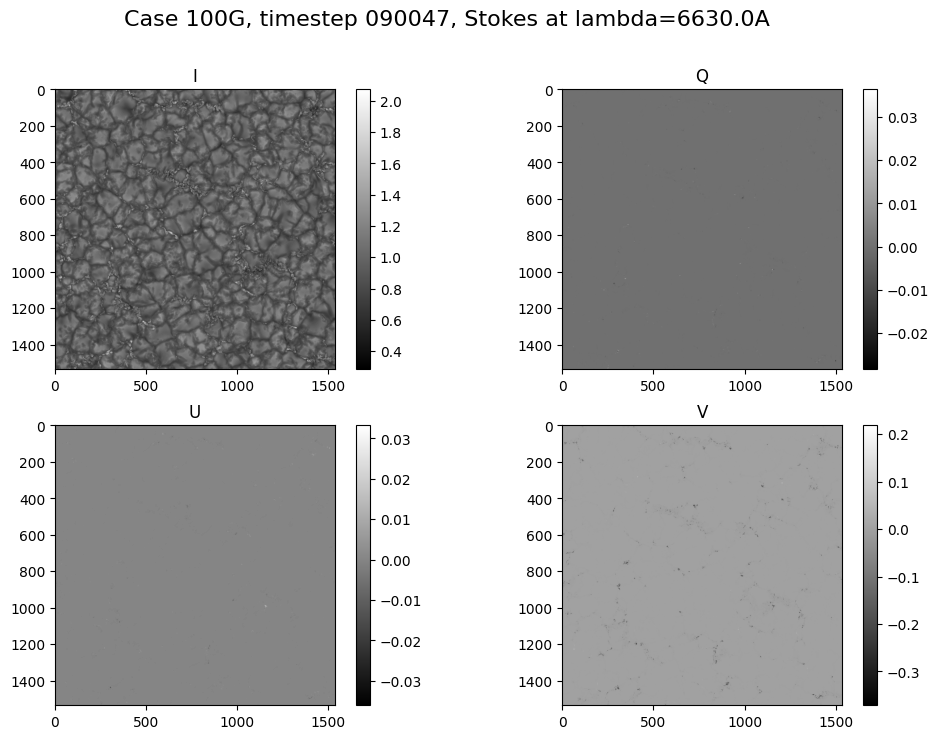

In [25]:
colormap="gray"
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Case %s, timestep %s, Stokes at lambda=%.1fA' %(DATA_MODEL, DATA_STEP, wave[wavelen]), fontsize=16)

plt.subplot(2, 2, 1)
plt.imshow(si[:,:,200],cmap=colormap)
plt.title('I')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(sq[:,:,200],cmap=colormap)
plt.title('Q')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(su[:,:,200],cmap=colormap)
plt.title('U')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(sv[:,:,200],cmap=colormap)
plt.title('V')
plt.colorbar()

---
# Quiet Sun and Granules

The Intensity map shows what one might see through a telescope. 
There are visible granules, convective cells in the Sun's atmosphere.

Other features may be observed. The Q, U and V plots above showed effectively no polarized light. Note the intensity scale shown on the colorbar at the right for Q, U and V. The V signal is about 1000x less than I. U and V are about 100,000x less than I! We see that Q, U and V have very low signal at the wavelength that we have plotted (intentionally).

What could we do to plot Q, U and V images that show a stronger signal?

Hint: we selected the wavelength bin 100 above but there are other wavelengths we could choose.

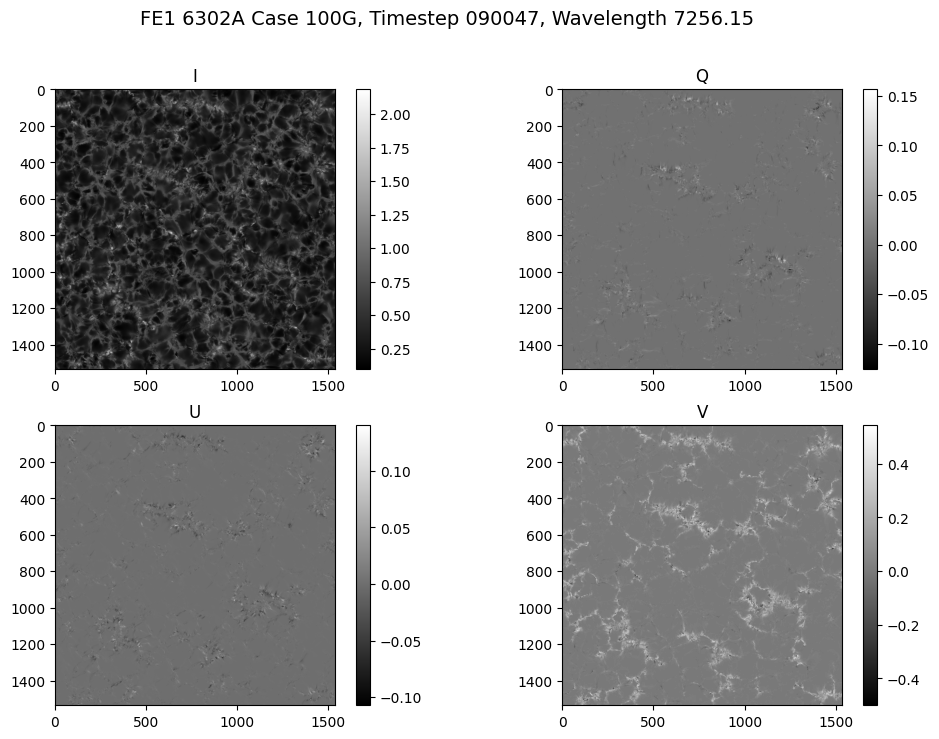

In [26]:
wavelen=170
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

title='FE1 6302A Case {1}, Timestep {2}, Wavelength {0:.2f}'.format(wave[wavelen],DATA_MODEL, DATA_STEP)
fig.suptitle(title, fontsize=14)

plt.subplot(2, 2, 1)
plt.imshow(si[:,:,wavelen],cmap=colormap)
plt.title('I')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(sq[:,:,wavelen],cmap=colormap)
plt.title('Q')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(su[:,:,wavelen],cmap=colormap)
plt.title('U')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(sv[:,:,wavelen],cmap=colormap)
plt.title('V')
plt.colorbar()

---
# Butterfly plots
We choose bin 170 because it samples a wavelength where the polarization signal is stronger.

Let's shift our perspective and look along the wavelength dimension along a vertical stripe of the maps above.

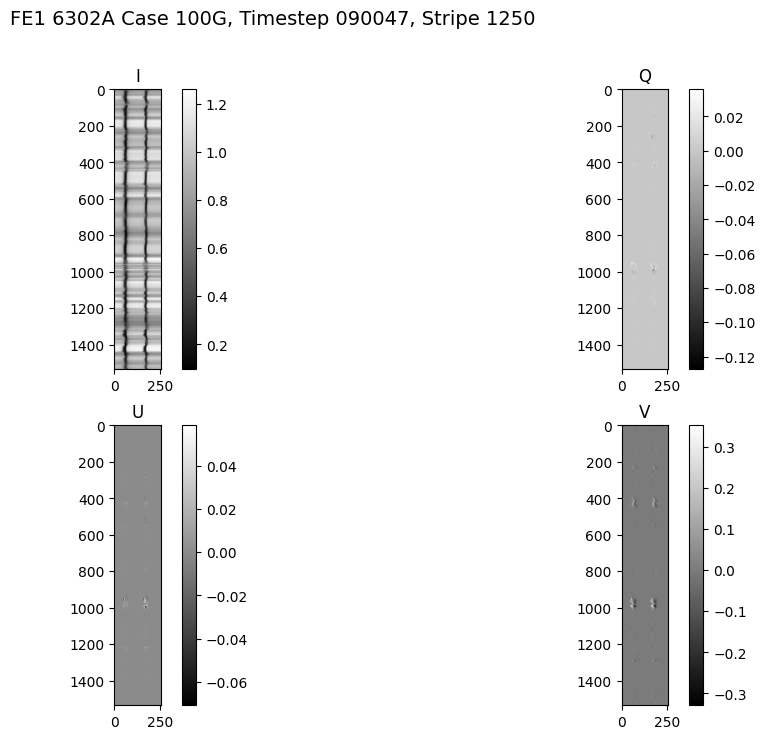

In [27]:
xpos=1250
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

title='FE1 6302A Case {2}, Timestep {3}, Stripe {1}'.format(0,xpos,DATA_MODEL, DATA_STEP)
fig.suptitle(title, fontsize=14)

plt.subplot(2, 2, 1)
plt.imshow(si[:,xpos,:],cmap=colormap)
plt.title('I')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(sq[:,xpos,:],cmap=colormap)
plt.title('Q')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(su[:,xpos,:],cmap=colormap)
plt.title('U')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(sv[:,xpos,:],cmap=colormap)
plt.title('V')
plt.colorbar()

---
# Spatial interpretation

Since this is a vertical slice (x=1250) through the spatial map you can see that only certain regions of y (around 400 and 1000) have a strong signal in the Q, U and V plots.

Also, note that the I plot shows the absorption lines around lambda=(60,170) but polarization signals are present only in specific spatial regions.

# Plotting Stokes Profiles

Now we will take yet another perspective and plot intensity vs wavelength for a single spatial "pixel" or line of sight. This could be done for every 2.3M in each timestep. We will just look at the position (500,500).

In [28]:
position = (500,500)
StokesI = si[position[0], position[1]]
StokesQ = sq[position[0],position[1]]
StokesU = su[position[0],position[1]]
StokesV = sv[position[0],position[1]]

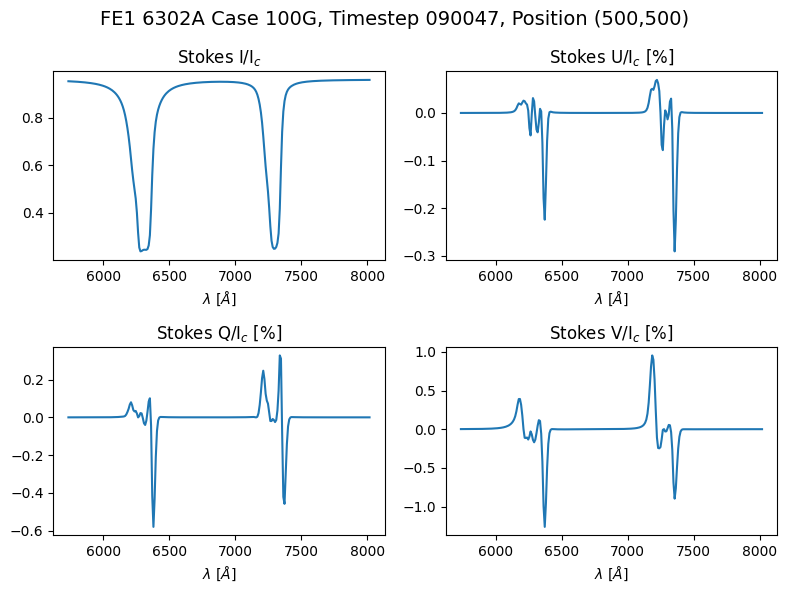

In [29]:
title='FE1 6302A Case {2}, Timestep {3}, Position ({0},{1})'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(2, 2)

fig.suptitle(title, fontsize=14)

im = axs[0, 0].plot(wave, StokesI)
axs[0, 0].set(xlabel='$\lambda$ [$\AA$]',title='Stokes I/I$_c$')

im = axs[0, 1].plot(wave, StokesQ*100.)
axs[0, 1].set(xlabel='$\lambda$ [$\AA$]',title='Stokes U/I$_c$ [%]')

im = axs[1, 0].plot(wave, StokesU*100.)
axs[1, 0].set(xlabel='$\lambda$ [$\AA$]',title='Stokes Q/I$_c$ [%]')

im = axs[1, 1].plot(wave, StokesV*100.)
axs[1, 1].set(xlabel='$\lambda$ [$\AA$]',title='Stokes V/I$_c$ [%]')

plt.tight_layout()
plt.show()

# Visualizing MURam Cubes

The **SPIN4D-DR1** dataset contains a subdirectory for each "case" or initial configuration of the MURaM simulation.

In [30]:
!ls ./data|grep SPIN4D_SSD

SPIN4D_SSD_100G


## Simulation MURaM cube snapshots

For a given simulation run there are ~20 snapshots of the MURaM cube parameter values.
The MURaM simulation grid is 1536 x 1536 x 128 or 1536 "pixels" square sampled at 128 levels in the (simulated) solar 
atmosphere.

##  MURaM cube dimensionality
The MURaM cube axes correspond to solar (X, Y, Z) where:
- Solar Y = North to South
- Solar X = East to West
- Solar Z = Center to Surface


Each snapshot consists of 12 files. Each file stores 1 of the 12 parameters. Each file contains a 3D numpy array with shape: (1536, 1536, 128).
The data is stored in the file in (X, Y, Z) order so we need to swap axes after reading in the data.
Each snapshot is uniquely identified by a sequence number suffix, e.g. **090047**.


In [31]:
!ls -l $DATA_PATH | grep $DATA_STEP | grep subdomain 

-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_0.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_1.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_10.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_11.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_2.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_3.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_4.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_5.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_6.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_7.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_8.090047
-rw-r--r-- 1 root root  1207959552 Jul 30  2022 subdomain_9.090047


## MURaM cube parameters

The following table is a key to mapping the numeric "subdomain_<n>" file names to recognizable parameters of physics equations.

Abbrev|File Name|Parameter
---|---|---
rho|subdomain_0|density
vx|subdomain_1|velocity_x
vy|subdomain_2|velocity_y
vz|subdomain_3|velocity_z
eint|subdomain_4|internal electron pressure
Bx|subdomain_5|magnetic field_x
By|subdomain_6|magnetic field_y
Bz|subdomain_7|magnetic field_z
T|subdomain_8|temperature
P|subdomain_9|pressure
ne|subdomain_10|number of electrons
tau500|subdomain_11|opacity at 500nm

In [32]:
cubeParam = {
  'rho': 'subdomain_0',
  'vx': 'subdomain_1',
  'vy': 'subdomain_2',
  'vz': 'subdomain_3',
  'eint': 'subdomain_4',
  'Bx': 'subdomain_5',
  'By': 'subdomain_6',
  'Bz': 'subdomain_7',
  'T': 'subdomain_8',
  'P': 'subdomain_9',
  'ne': 'subdomain_10',
  'tau': 'subdomain_11',
}

In [33]:
cube = {}

We provide a helper function to read and reshape a MURaM cube from a file.

In [34]:
def read_cube(param_key, model, sequence):
  paramPath = os.path.join("./data",'SPIN4D_SSD_{0}/'.format(model),cubeParam[param_key]+'.'+sequence)
  print('get {0} from {1}'.format(param_key, paramPath))
  tmp = np.fromfile(paramPath, dtype = np.float32)
  tmpa = tmp.reshape((1536,1536,128))
  return tmpa.transpose(1, 0, 2)

## Visualize slices of the Sun's atmosphere

We can visualize a cross sectional slice at half the depth of the cube grid (z = 64)
and plot a single line of sight looking from the center of the Sun to Earth (the surface of the Sun is at the right)

## Magnetic field strength

The magnetic field is described by 3 parameters: (Bx, By, Bz).

get Bz from ./data/SPIN4D_SSD_100G/subdomain_7.090047


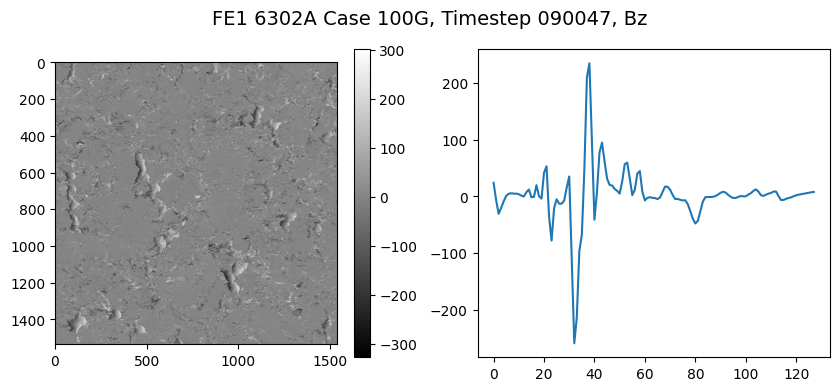

In [35]:
cube['Bz'] = read_cube('Bz', DATA_MODEL, DATA_STEP)
cube['Bz'].shape

title='FE1 6302A Case {2}, Timestep {3}, Bz'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['Bz'][:,:,64],cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(cube['Bz'][750,750,:])
cube['Bz'] = []

get Bx from ./data/SPIN4D_SSD_100G/subdomain_5.090047


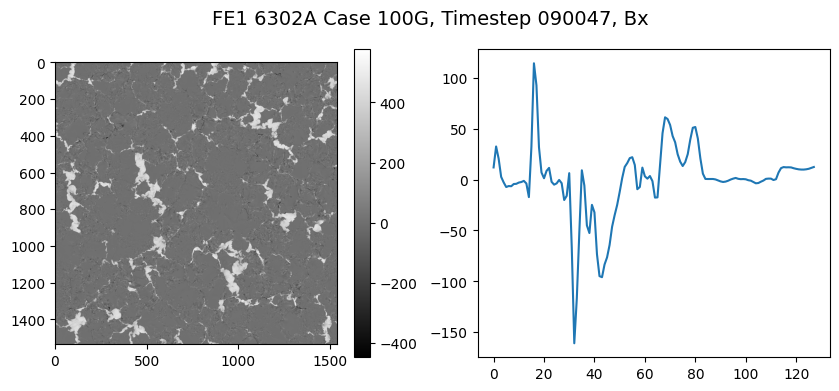

In [36]:
cube['Bx'] = read_cube('Bx', DATA_MODEL, DATA_STEP)
cube['Bx'].shape

title='FE1 6302A Case {2}, Timestep {3}, Bx'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['Bx'][:,:,64],cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(cube['Bx'][750,750,:])
cube['Bx'] = []

get By from ./data/SPIN4D_SSD_100G/subdomain_6.090047


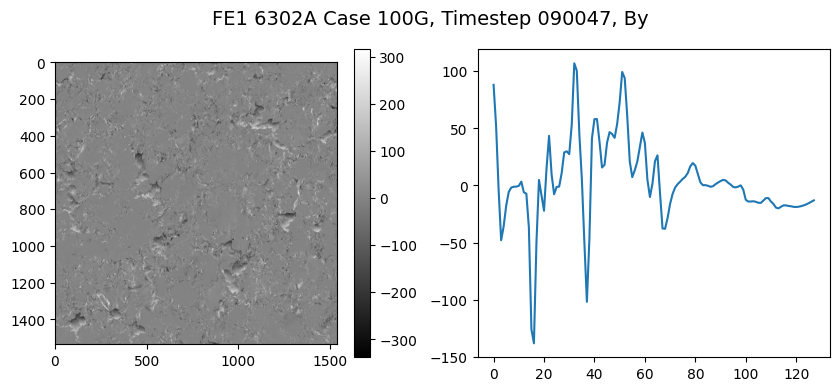

In [37]:
cube['By'] = read_cube('By', DATA_MODEL, DATA_STEP)
cube['By'].shape

title='FE1 6302A Case {2}, Timestep {3}, By'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['By'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['By'][750,750,:])
cube['By'] = []

## Temperature, Pressure and Density

get T from ./data/SPIN4D_SSD_100G/subdomain_8.090047


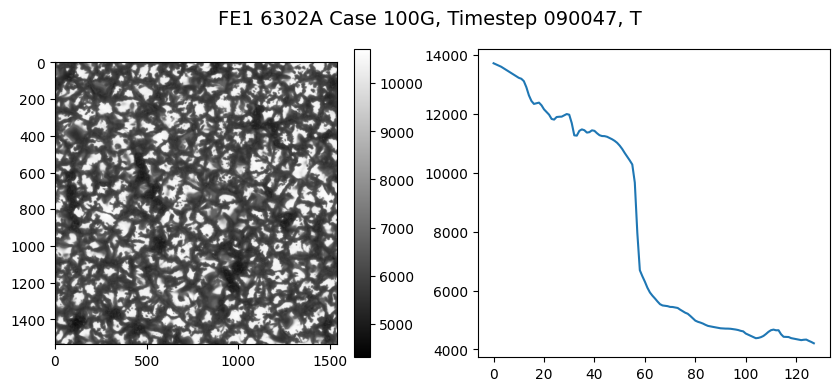

In [38]:
cube['T'] = read_cube('T', DATA_MODEL, DATA_STEP)
cube['T'].shape

title='FE1 6302A Case {2}, Timestep {3}, T'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['T'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['T'][750,750,:])
cube['T'] = []

get P from ./data/SPIN4D_SSD_100G/subdomain_9.090047


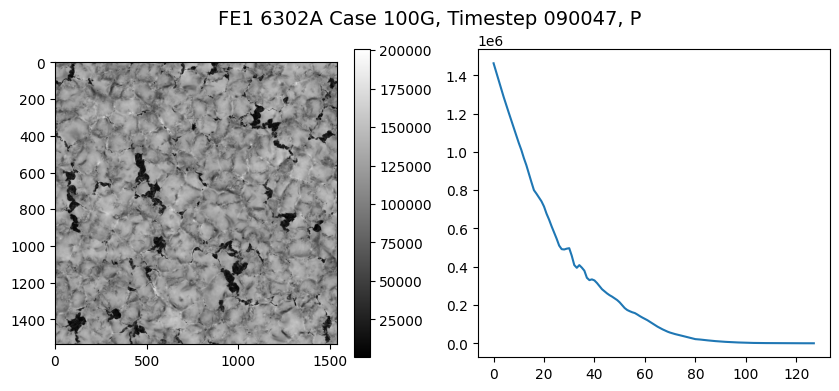

In [39]:
cube['P'] = read_cube('P', DATA_MODEL, DATA_STEP)
cube['P'].shape

title='FE1 6302A Case {2}, Timestep {3}, P'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['P'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['P'][750,750,:])
cube['P'] = []

get rho from ./data/SPIN4D_SSD_100G/subdomain_0.090047


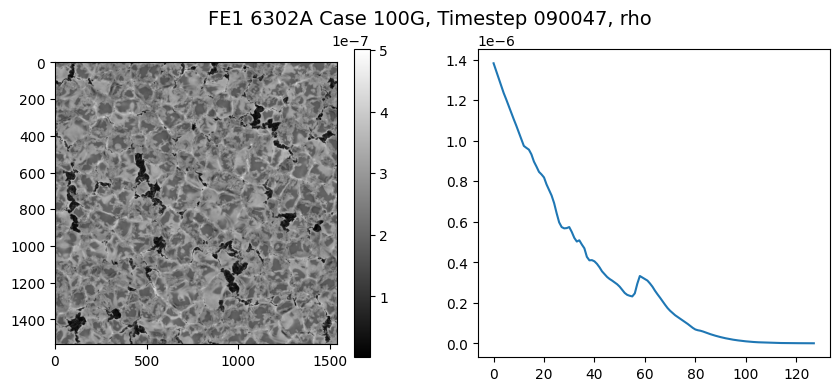

In [40]:
cube['rho'] = read_cube('rho', DATA_MODEL, DATA_STEP)
cube['rho'].shape

title='FE1 6302A Case {2}, Timestep {3}, rho'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['rho'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['rho'][750,750,:])
cube['rho'] = []

## Number of electrons, internal electron pressure

get ne from ./data/SPIN4D_SSD_100G/subdomain_10.090047


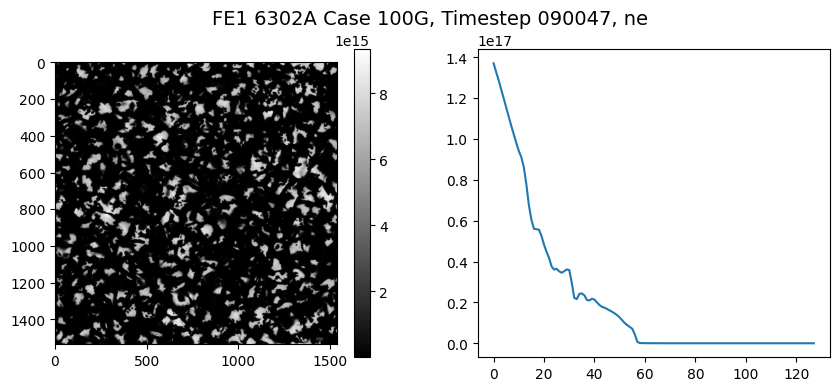

In [41]:
cube['ne'] = read_cube('ne', DATA_MODEL, DATA_STEP)
cube['ne'].shape

title='FE1 6302A Case {2}, Timestep {3}, ne'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['ne'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['ne'][750,750,:])
cube['ne'] = []

get eint from ./data/SPIN4D_SSD_100G/subdomain_4.090047


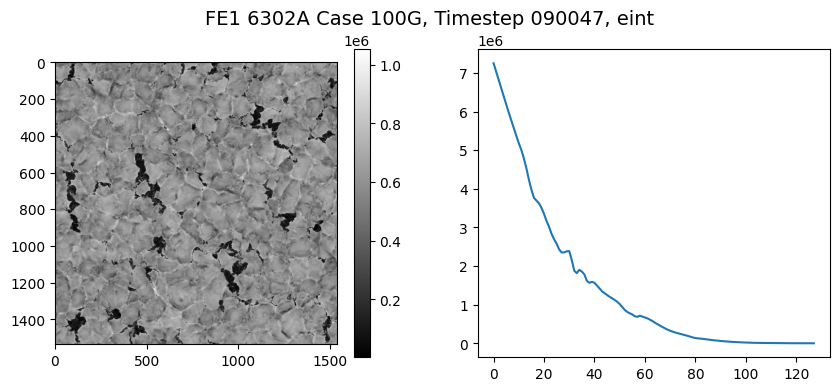

In [42]:
cube['eint'] = read_cube('eint', DATA_MODEL, DATA_STEP)
cube['eint'].shape

title='FE1 6302A Case {2}, Timestep {3}, eint'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['eint'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['eint'][750,750,:])
cube['eint'] = []

## Opacity

By convention opacity (tau) is integrated at 500nm

get tau from ./data/SPIN4D_SSD_100G/subdomain_11.090047


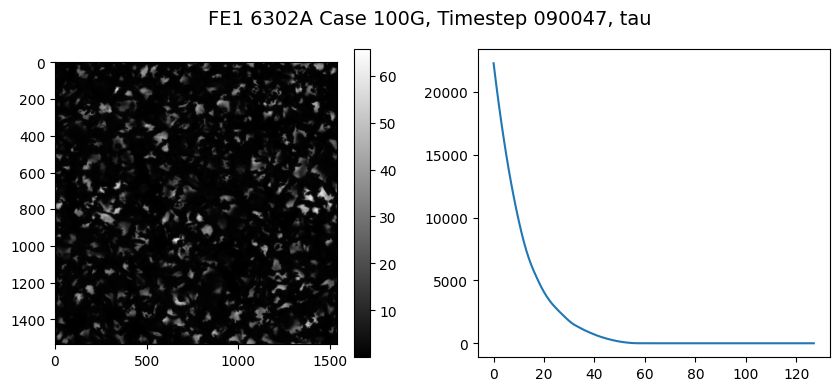

In [43]:
cube['tau'] = read_cube('tau', DATA_MODEL, DATA_STEP)
cube['tau'].shape

title='FE1 6302A Case {2}, Timestep {3}, tau'.format(position[0],position[1],DATA_MODEL, DATA_STEP)

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
fig, axs = plt.subplots(1, 2)
fig.suptitle(title, fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(cube['tau'][:,:,64],cmap="gray")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.plot(cube['tau'][750,750,:])
cube['tau'] = []